In [1]:
import numpy as np
import pandas as pd
import os
from matplotlib import pyplot as plt
import re
from copy import deepcopy

In [2]:
domain_list = ["origin", "brightness", "contrast", "defocus_blur", "gaussian_noise", ]
checkitew_list = ["bottle", "cable", "capsule", "carpet", "grid", "hazelnut", "leather", "metal_nut", "pill", "screw", "tile", "toothbrush", "transistor", "wood", "zipper", ]
metric = "AUPRC"

dir_path = '../results/MVTEC/devnet/4domain'
dir_path = '../results/MVTEC/DGAD/method13_MVTEC'

dir_path = '../results/MVTEC/DGAD/method16'
# dir_path = '../results/MVTEC/DGAD/method16_severity5'
# dir_path = '../results/MVTEC/devnet/4domain_s5'
# dir_path = '../results/MVTEC/devnet/4domain'

# dir_path = '../results/MVTEC/DGAD/method16_transistor'
# dir_path = '../results/MVTEC/DGAD/method16_transistor_lambda'
# dir_path = '../results/MVTEC/DGAD/method16_toothbrush_lambda'
# dir_path = '../results/MVTEC/DGAD/method16_transistor_tau'

In [3]:
import itertools
# normal_class=["0", "1", "2", "3", "4", "5", "6"]
# normal_class=["0 1 2 3", "4 5 6", "0 2 4 6", "1 3 5", "0", "1", "2", "3", "4", "5", "6"]
# anomaly_class=["4 5 6", "0 1 2 3", "1 3 5", "0 2 4 6", "1 2 3 4 5 6", "0 2 3 4 5 6", "0 1 3 4 5 6", "0 1 2 4 5 6", "0 1 2 3 5 6", "0 1 2 3 4 6", "0 1 2 3 4 5"]
# epochs_list=[5, 10, 15, 20, 30]
# lr_list=[0.01, 0.001, 0.0005, 0.0002, 0.00005, 0.00001]
reg_lambda=[1,2,5,10]
NCE_lambda=[1,2,5,10]
PL_lambda=[1,2,5,10]
# cnt=[0,1,2,3,4]
cnt=[0]
all_para_list = list(itertools.product(reg_lambda, NCE_lambda, PL_lambda, cnt))
print(len(all_para_list))
all_para_list[0]

64


(1, 1, 1, 0)

In [4]:
ans = []
# para_name_list=["checkitew", "pre_lr", "pre_epochs", "lr", "epochs", "cnt"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2"]
para_name_list=["checkitew", "lr", "epochs", "cnt",]
if dir_path.__contains__("lambda"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "reg_lambda", "NCE_lambda", "PL_lambda", "class_lambda"]
if dir_path.__contains__("tau"):
    para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2",]
# para_name_list=["checkitew", "lr", "epochs", "cnt","reg_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "tau1", "tau2", "reg_lambda", "NCE_lambda", "PL_lambda"]
# para_name_list=["checkitew", "lr", "epochs", "cnt", "origin_svdd_lambda", "class_svdd_lambda", "align_lambda", "beta"]
print(len(os.listdir(dir_path)))
for file_name in os.listdir(dir_path):
    record = []
    data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
    max_epoch = data["val_max_metric"].item()["epoch"]
    # max_epoch = [i for i, val in enumerate(data[f"val_{metric}_list"]) if (val == max(data[f"val_{metric}_list"]))][-1]
    
    for key in para_name_list:
        if key in data["args"].item():
            record.append(data["args"].item()[key])
        else:
            record.append(1.0)
    
    record.append(max_epoch)

    if "metric" in data["val_max_metric"].item():
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(0)
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUROC"])
        for key in domain_list:
            record.append(data["val_max_metric"].item()["metric"][key]["AUPRC"])
    else:
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUROC"])
        for key in domain_list:
            record.append(data["test_metric"].item()[key]["AUPRC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUROC"])
        for key in domain_list:
            record.append(data["test_results_list"][max_epoch][key]["AUPRC"])

    record.append(file_name)
    ans.append(record)

ans = pd.DataFrame(ans,columns=para_name_list + ["max_val_epoch"] +\
             [f'{item}_AUROC' for item in domain_list] + \
                [f'{item}_AUPRC' for item in domain_list] +\
                    [f'val_{item}_AUROC' for item in domain_list] +\
                        [f'val_{item}_AUPRC' for item in domain_list] + ["file_name"])

ans["checkitew"] = ans["checkitew"].astype(str)
ans["AUROC_mean"] = ans[[f'{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["AUPRC_mean"] = ans[[f'{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["val_AUROC_mean"] = ans[[f'val_{item}_AUROC' for item in domain_list]].mean(axis = 1)
ans["val_AUPRC_mean"] = ans[[f'val_{item}_AUPRC' for item in domain_list]].mean(axis = 1)
ans["checkitew"] = ans["checkitew"].apply(lambda x :re.sub("\[|\]|,", "", x))
ans.head(5)

416


,checkitew,lr,epochs,cnt,max_val_epoch,origin_AUROC,brightness_AUROC,contrast_AUROC,defocus_blur_AUROC,gaussian_noise_AUROC,...,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,AUROC_mean,AUPRC_mean,val_AUROC_mean,val_AUPRC_mean
0,transistor,0.00010,40,0,16,0,0,0,0,0,...,0.531157,0.584570,0.536747,0.571515,0.734316,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.587454,0.591661
1,bottle,0.00005,20,2,6,0,0,0,0,0,...,0.990720,0.992115,0.999180,0.992849,0.994277,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.979104,0.993828
2,zipper,0.00050,10,0,3,0,0,0,0,0,...,0.859144,0.859487,0.850264,0.873681,0.836830,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.568186,0.855881
3,bottle,0.00010,20,0,2,0,0,0,0,0,...,0.995778,0.990655,0.997842,0.987234,0.997960,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.979758,0.993894
4,metal_nut,0.00001,40,0,39,0,0,0,0,0,...,0.979762,0.977047,0.975039,0.977930,0.961893,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.0,0.0,0.894861,0.974334


In [5]:
ans["checkitew"].value_counts()

bottle        48
cable         48
capsule       32
metal_nut     24
hazelnut      24
transistor    24
zipper        24
screw         24
wood          24
carpet        24
tile          24
toothbrush    24
grid          24
leather       24
pill          24
Name: checkitew, dtype: int64

In [6]:
# ans = ans[ans["epochs"] != 2]
# if dir_path.__contains__("devnet"):
#     ans = ans[ans["lr"] != 0.00005]

In [7]:
ans.cnt.value_counts()

0    180
1    180
2     56
Name: cnt, dtype: int64

In [8]:
# pre_epochs_list = [10, 30, 50, 100]
# pre_lr_list = [0.01, 0.001, 0.0001]
# epochs_list = [10, 20, 30]
# lr_list = [0.00001, 0.0001, 0.001]
# cnt = [0, 1]
# all_para_list = list(itertools.product(cnt, pre_epochs_list, pre_lr_list, epochs_list, lr_list))
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["cnt", "pre_epochs", "pre_lr", "epochs", "lr"]].values])
# remain_para = pd.DataFrame(sorted(remain_para), columns=["cnt", "pre_epochs", "pre_lr", "epochs", "lr"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [9]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[(ans["epochs"]==30) & (ans["lr"]==0.00005) & (ans["cnt"] == 0)][["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["reg_lambda", "NCE_lambda", "PL_lambda", "cnt"])
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# # remain_para
# len(remain_para)

In [10]:
# remain_para = set(all_para_list) - set([tuple(item) for item in ans[["normal_class", "epochs", "lr", "cnt"]].values])
# remain_para = pd.DataFrame(remain_para, columns=["normal_class", "epochs", "lr", "cnt"])
# remain_para.insert(1,"anomaly_class", remain_para.apply(lambda x: re.sub("\{|,|\}","", str(set([0,1,2,3,4,5,6]) - set(map(int, x["normal_class"].split(" "))))), axis=1))
# print(f"./{dir_path.split('/')[-1]}_remain_para.csv")
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [11]:
if metric == "AUPRC":
    columns_to_drop = ans.filter(like='AUROC').columns.to_list()
    columns_to_drop.remove("val_AUROC_mean")
else:
    columns_to_drop = ans.filter(like='AUPRC').columns.to_list()
    columns_to_drop.remove("val_AUPRC_mean")
columns_to_drop = columns_to_drop + [f'{item}_{metric}' for item in domain_list] + [f"{metric}_mean"]
ans = ans.drop(columns=columns_to_drop) 
columns_to_drop

['origin_AUROC',
 'brightness_AUROC',
 'contrast_AUROC',
 'defocus_blur_AUROC',
 'gaussian_noise_AUROC',
 'val_origin_AUROC',
 'val_brightness_AUROC',
 'val_contrast_AUROC',
 'val_defocus_blur_AUROC',
 'val_gaussian_noise_AUROC',
 'AUROC_mean',
 'origin_AUPRC',
 'brightness_AUPRC',
 'contrast_AUPRC',
 'defocus_blur_AUPRC',
 'gaussian_noise_AUPRC',
 'AUPRC_mean']

In [12]:
agg_method = {"cnt":["count"],
              "max_val_epoch":["mean", "std"],
              f"val_{metric}_mean":["mean", "std"],}
for item in domain_list:
    agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
total_avg = dict()
for checkitew in checkitew_list:
    checkitew = str(checkitew)
    selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
    # group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
    group_key = list(set(para_name_list) - set(["checkitew", "cnt"]))
    group_key.sort()
    # print(group_key)
    selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
    selected_para = selected_records_anslysis.index[0]
    # print(selected_para)
    selected_records_anslysis

    filter = None
    for idx, item in enumerate(group_key):
        if filter is None:
            filter = selected_records[item] == selected_para[idx]
        else:
            filter = filter & (selected_records[item] == selected_para[idx])
    temp = selected_records[filter].agg(["mean", "std"]).T
    temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
    for key in [f'val_{item}_{metric}' for item in domain_list]:
        print(temp.loc[key]["res"])
        if key not in total_avg:
            total_avg[key] = []
        total_avg[key].append(temp.loc[key]["res"])
    print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
    selected_records[filter]

total_domain_avg = []
for key in [f'val_{item}_{metric}' for item in domain_list]:
    value = total_avg[key]
    total_domain_avg.append(round(np.array(list(map(lambda x: float(x.split("(")[0]), value))).mean(), 2))
    print(total_domain_avg[-1])
print(round(np.mean(total_domain_avg), 2))

/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these colu

99.43(0.32)
99.41(0.4)
99.7(0.23)
99.53(0.17)
99.62(0.17)
99.54(0.17)
85.66(0.48)
91.16(0.27)
89.49(1.05)
85.38(0.65)
92.1(0.51)
88.76(0.28)
96.1(0.62)
94.05(0.38)
94.83(1.28)
95.82(0.28)
92.06(1.02)
94.57(0.19)
96.89(0.63)
95.19(0.05)
95.29(0.61)
95.33(0.53)
96.84(0.5)
95.91(0.22)
80.32(2.23)
85.11(1.53)
84.46(2.13)
78.07(1.1)
86.52(1.95)
82.9(1.18)
99.32(0.22)
99.12(0.53)
98.91(0.43)
99.17(0.01)
98.63(0.41)
99.03(0.23)
99.25(0.12)
98.89(0.15)
98.94(0.45)
98.15(1.03)
97.26(0.56)
98.5(0.17)
97.84(0.06)
98.14(0.32)
97.39(0.05)
97.81(0.02)
96.08(0.04)
97.45(0.05)
94.37(0.48)
94.43(1.05)
90.64(0.35)
94.46(0.75)
91.92(0.04)
93.16(0.39)
92.88(1.94)
91.01(0.11)
86.84(2.21)
93.07(0.11)
73.33(5.67)
87.43(1.96)
98.71(0.02)
98.34(0.35)
98.19(0.53)
96.6(0.72)
97.64(0.76)
97.89(0.25)
78.48(1.1)
81.46(1.57)
83.78(5.49)
88.01(2.54)
79.83(0.61)
82.31(1.82)
76.69(2.14)
81.84(11.64)
78.01(6.72)
74.85(4.4)
79.93(1.25)
78.26(2.11)
95.95(1.9)
97.05(0.23)
97.31(0.02)
92.52(4.54)
95.16(0.71)
95.6(1.38)
98.4

/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T
/tmp/ipykernel_80991/315919129.py:28: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T


In [13]:
# ans[(ans["normal_class"] == normal_class)].sort_values(by="val_AUROC_mean",ascending=False)

In [14]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(list(item))
# remain_para = pd.DataFrame(remain_para)
# remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)

In [15]:
# remain_para = []
# for item in selected_records_anslysis.index[:10]:
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],2])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],3])
#     remain_para.append(["0","1 2 3 4 5 6",item[1],item[0],4])
    
# remain_para = pd.DataFrame(remain_para,columns=["normal_class", "anomaly_class", "epochs", "lr", "cnt"])
# # remain_para.to_csv(f"./{dir_path.split('/')[-1]}_remain_para.csv",index=None, header=None)
# remain_para

In [16]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 1, 1, 0),:]

In [17]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 0, 1, 0),:]

In [18]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 1, 0, 0, 0),:]

In [19]:
# selected_records_anslysis.sort_index().loc[(slice(None), slice(None), 0, 0, 0, 0),:]

In [20]:
agg_method = {"cnt":["count"],
              "max_val_epoch":["mean", "std"]}
for item in domain_list:
    agg_method[f"val_{item}_{metric}"] = ["mean", "std"]

agg_method[f"val_{metric}_mean"] = ["mean", "std"]
agg_method[f"val_{metric}_mean"] = ["mean", "std"]

pd.set_option("display.max_columns",None)
pd.set_option("display.max_rows",None)
checkitew = 'transistor'
selected_records = ans[ans["checkitew"] == checkitew].drop(["checkitew"],axis=1)
# group_key = ["pre_lr", "pre_epochs", "lr", "epochs"]
group_key = deepcopy(para_name_list)
group_key.remove("checkitew")
group_key.remove("cnt")
print(group_key)
selected_records_anslysis = selected_records.groupby(group_key).agg(agg_method).sort_values(by=(f"val_{metric}_mean", "mean"), ascending=False)
selected_para = selected_records_anslysis.index[0]
print(selected_para)
selected_records_anslysis

['lr', 'epochs']
(5e-05, 20)


cnt max_val_epoch            val_origin_AUPRC            \
               count          mean        std             mean       std   
lr      epochs                                                             
0.00005 20         2           3.5   4.949747         0.766854  0.021381   
0.00010 10         2           1.5   0.707107         0.770997  0.065845   
        20         2           1.0   0.000000         0.734473  0.038423   
0.00005 10         2           0.0   0.000000         0.763122  0.025948   
        40         2          13.5   2.121320         0.684890  0.086782   
0.00001 40         2          17.5  24.748737         0.745704  0.105518   
0.00050 20         2           2.5   0.707107         0.726668  0.003920   
0.00001 20         2           1.0   0.000000         0.740214  0.029951   
0.00050 10         2           5.0   2.828427         0.701932  0.018652   
0.00010 40         2          20.0   5.656854         0.574628  0.061478   
0.00050 40         2           1.0   1.414214         0.633479  0.050356   
0.00001 10         2           0.0   0.000000         0.617787  0.051562   

               val_brightness_AUPRC           val_contrast_AUPRC            \
                               mean       std               mean       std   
lr      epochs                                                               
0.00005 20                 0.818382  0.116392           0.780110  0.067174   
0.00010 10                 0.841281  0.077572           0.794960  0.002390   
        20                 0.788732  0.042282           0.749666  0.015610   
0.00005 10                 0.768418  0.038804           0.746709  0.056391   
        40                 0.833579  0.029973           0.748073  0.022496   
0.00001 40                 0.802514  0.099033           0.744097  0.151868   
0.00050 20                 0.756397  0.064049           0.706216  0.000285   
0.00001 20                 0.703795  0.019732           0.700026  0.073930   
0.00050 10                 0.704817  0.043923           0.650756  0.102753   
0.00010 40                 0.619215  0.048996           0.608880  0.102010   
0.00050 40                 0.561147  0.105314           0.584094  0.064007   
0.00001 10                 0.607803  0.009346           0.577812  0.142034   

               val_defocus_blur_AUPRC           val_gaussian_noise_AUPRC  \
                                 mean       std                     mean   
lr      epochs                                                             
0.00005 20                   0.748472  0.044020                 0.799259   
0.00010 10                   0.710143  0.006424                 0.744865   
        20                   0.716655  0.001354                 0.818393   
0.00005 10                   0.733881  0.008953                 0.782028   
        40                   0.687366  0.002530                 0.757725   
0.00001 40                   0.717923  0.078000                 0.692060   
0.00050 20                   0.667506  0.101543                 0.760875   
0.00001 20                   0.661971  0.023152                 0.707467   
0.00050 10                   0.635045  0.099266                 0.679339   
0.00010 40                   0.596510  0.035349                 0.748348   
0.00050 40                   0.643129  0.128762                 0.682946   
0.00001 10                   0.617461  0.025243                 0.599553   

                         val_AUPRC_mean            
                     std           mean       std  
lr      epochs                                     
0.00005 20      0.012467       0.782615  0.021139  
0.00010 10      0.014615       0.772449  0.032413  
        20      0.040376       0.761584  0.004452  
0.00005 10      0.034828       0.758832  0.029404  
        40      0.018657       0.742327  0.024625  
0.00001 40      0.120659       0.740459  0.111016  
0.00050 20      0.067370       0.723532  0.047320  
0.00001 20      0.002023       0.702695  0.0

In [21]:
filter = None
for idx, item in enumerate(group_key):
    if filter is None:
        filter = selected_records[item] == selected_para[idx]
    else:
        filter = filter & (selected_records[item] == selected_para[idx])
temp = selected_records[filter].agg(["mean", "std"]).T
temp["res"] = temp.apply(lambda x: f'{round(x["mean"] *100, 2)}({round(x["std"] *100, 2)})', axis=1)
for key in [f'val_{item}_{metric}' for item in domain_list]:
    print(temp.loc[key]["res"])
print(f'{round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["mean"] * 100, 2)}({round(selected_records_anslysis.loc[selected_para][f"val_{metric}_mean"]["std"] * 100, 2)})')
selected_records[filter]

76.69(2.14)
81.84(11.64)
78.01(6.72)
74.85(4.4)
79.93(1.25)
78.26(2.11)


/tmp/ipykernel_80991/1079342940.py:7: FutureWarning: ['file_name'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  temp = selected_records[filter].agg(["mean", "std"]).T


,lr,epochs,cnt,max_val_epoch,val_origin_AUPRC,val_brightness_AUPRC,val_contrast_AUPRC,val_defocus_blur_AUPRC,val_gaussian_noise_AUPRC,file_name,val_AUROC_mean,val_AUPRC_mean
162,0.00005,20,0,0,0.781973,0.736081,0.732611,0.779599,0.808075,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.801167,0.767668
323,0.00005,20,1,7,0.751736,0.900683,0.827609,0.717345,0.790443,"method=16,backbone=DGAD15,domain_cnt=4,checkit...",0.817620,0.797563


In [22]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

NpzFile '../results/MVTEC/DGAD/method16/method=16,backbone=DGAD15,domain_cnt=4,checkitew=transistor,batch_size=30,steps_per_epoch=20,epochs=20,lr=5e-05,reg_lambda=1.0,NCE_lambda=1.0,PL_lambda=1.0,cnt=0.npz' with keys: val_max_metric, train_results_loss, sub_train_results_loss, val_results_loss, val_AUROC_list...

In [23]:
# # data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
# file_name = 'results/DEBUG/method=10,backbone=DGAD9,domain_cnt=3,normal_class=[0],anomaly_class=[1, 2, 3, 4, 5, 6],batch_size=30,steps_per_epoch=20,epochs=40,lr=5e-05,tau1=0.07,tau2=0.07,origin_svdd_lambda=1.0,class_svdd_lambda=1.0,align_lambda=1.0,beta=0.9,cnt=0.npz'
# data = np.load(f'../{file_name}', allow_pickle=True)
# data

In [24]:
domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

### 训练过程中 模型在test上下降趋势

0
origin [0.7819728442157768, 0.7281442722708276, 0.7817587750579732, 0.7453536393522376, 0.7291516360810715]
brightness [0.736080746431278, 0.8092848350822719, 0.8624728525834635, 0.824996979845076, 0.8155166038831468]
contrast [0.7326107307304045, 0.7763220140411885, 0.7935119206354271, 0.7771169834567297, 0.7748999698108808]
defocus_blur [0.7795990545555265, 0.7274220602278726, 0.7438067517277186, 0.6555588528043598, 0.686596078195768]
gaussian_noise [0.8080745457095468, 0.8180058987521452, 0.781262355256621, 0.7824276150269736, 0.788169592555408]


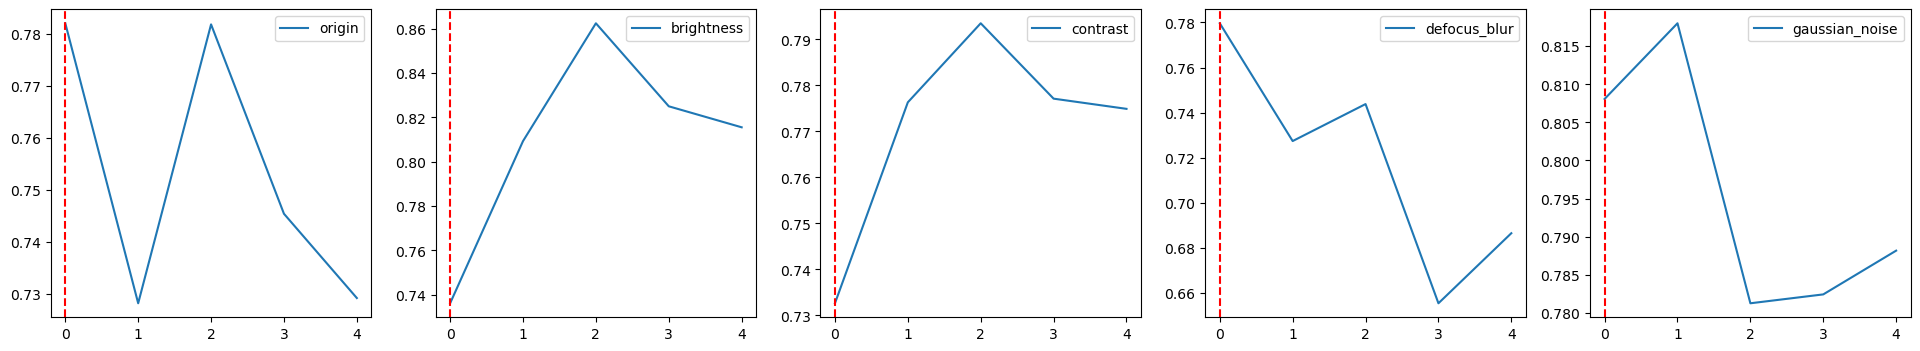

0
origin 0.7819728442157768
brightness 0.736080746431278
contrast 0.7326107307304045
defocus_blur 0.7795990545555265
gaussian_noise 0.8080745457095468


In [25]:
max_val_epoch = data["val_max_metric"].item()['epoch']
print(max_val_epoch)

fig, ax = plt.subplots(1,5, figsize=(24, 4))

for idx, domain in enumerate(domain_list):
    ax[idx].plot(domain_test_trends[domain][metric], label = domain)
    print(domain, domain_test_trends[domain][metric])

    if "metric" in data["val_max_metric"].item():
        if "test_epoch" in data["args"].item():
            ax[idx].axvline(x=max_val_epoch / data["args"].item()["test_epoch"], color='r', linestyle='--')
        else:
            ax[idx].axvline(x=max_val_epoch / 5, color='r', linestyle='--')
    else:
        ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')

    ax[idx].legend()
plt.show()

print(max_val_epoch)
if "metric" in data["val_max_metric"].item():
    for domain in domain_list:
        print(domain, data["val_max_metric"].item()["metric"][domain][metric])
else:
    for domain in domain_list:
        print(domain, domain_test_trends[domain][metric][max_val_epoch])

In [26]:
file_name = selected_records[filter].file_name.iloc[0]
data = np.load(f'{dir_path}/{file_name}', allow_pickle=True)
data

domain_test_trends = dict()
for domain in domain_list:
    domain_test_trends[domain]={
        "test_loss_list":[],
        "AUROC":[],
        "AUPRC":[],
    }

domain_test_trends
for res in data["test_results_list"]:
    if res is not None:
        for key in res:
            domain_test_trends[key]["test_loss_list"].append(np.array(res[key]["test_loss_list"]).mean())
            domain_test_trends[key]["AUROC"].append(res[key]["AUROC"])
            domain_test_trends[key]["AUPRC"].append(res[key]["AUPRC"])

tmp = []
for idx, domain in enumerate(domain_list):
    tmp.append(domain_test_trends[domain][metric])
tmp = pd.DataFrame(tmp, index=domain_list)
idx = tmp.mean(axis = 0).idxmax()
print(idx)
pd.concat([tmp, pd.DataFrame(tmp.mean(axis = 0), columns = ["avg"]).T])

2


,0,1,2,3,4
origin,0.781973,0.728144,0.781759,0.745354,0.729152
brightness,0.736081,0.809285,0.862473,0.824997,0.815517
contrast,0.732611,0.776322,0.793512,0.777117,0.774900
defocus_blur,0.779599,0.727422,0.743807,0.655559,0.686596
gaussian_noise,0.808075,0.818006,0.781262,0.782428,0.788170
avg,0.767668,0.771836,0.792563,0.757091,0.758867


### 训练集loss下降趋势

array([ 4.63899781,  2.71027662,  1.15550232,  0.81036566,  0.56993911,
        0.30176854,  0.02214649, -0.30870947, -0.47735266, -0.47830081,
       -0.49279189, -0.49642642, -0.52179439, -0.51796232, -0.49761311,
       -0.53555062, -0.50790666, -0.5396594 , -0.53986328, -0.54735556])

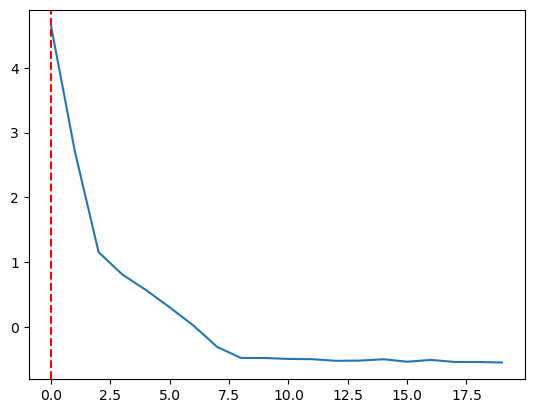

In [27]:
plt.plot(data["train_results_loss"].mean(axis=1)[0:])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["train_results_loss"].mean(axis=1)

### 训练过程中，模型在val 下降趋势

#### 验证集loss下降趋势

array([0.18375119, 0.3858901 , 0.20155136, 0.23165034, 0.22010247,
       0.22289702, 0.17349901, 0.15244819, 0.14431142, 0.14397829,
       0.14643846, 0.15097437, 0.15987909, 0.14963797, 0.1584625 ,
       0.15016288, 0.14746753, 0.15687179, 0.1455818 , 0.14763019])

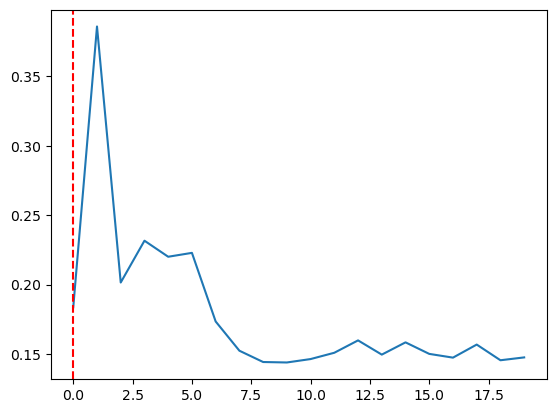

In [28]:
plt.plot(data["val_results_loss"].mean(axis=1))
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
data["val_results_loss"].mean(axis=1)

#### 验证集AUROC

array([0.58333333, 0.42836257, 0.27923977, 0.28508772, 0.2748538 ,
       0.34502924, 0.37134503, 0.41081871, 0.49122807, 0.52777778,
       0.44590643, 0.4254386 , 0.42836257, 0.46052632, 0.43274854,
       0.40789474, 0.4005848 , 0.37134503, 0.3494152 , 0.36111111])

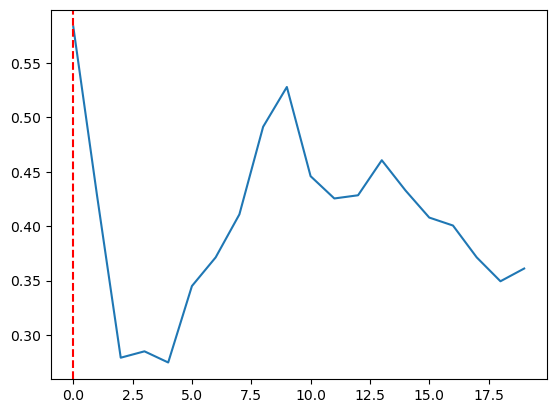

In [29]:
plt.plot(data[f"val_AUROC_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_AUROC_list"]

array([0.03243629, 0.02405319, 0.01895078, 0.01904494, 0.01913884,
       0.02082606, 0.02151713, 0.02488393, 0.02832555, 0.03028081,
       0.02483186, 0.02344051, 0.02377477, 0.02518049, 0.02373136,
       0.02305577, 0.02289415, 0.02149796, 0.02085   , 0.02123171])

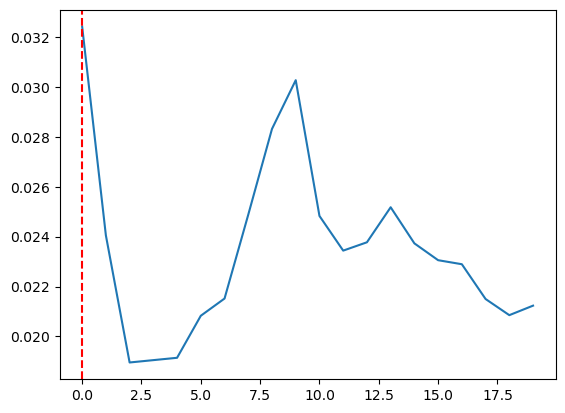

In [30]:
plt.plot(data[f"val_{metric}_list"])
plt.axvline(x=max_val_epoch, color='r', linestyle='--')
# plt.ylim(0.5,1)
data[f"val_{metric}_list"]

[2.47871454 2.3735634  2.15103177 1.91214298 1.64041757 1.41465961
 1.1681886  0.81859918 0.69943219 0.67002067 0.65719557 0.68017396
 0.63780826 0.6609156  0.67336203 0.65322313 0.66750776 0.63574634
 0.66376733 0.6477708 ]


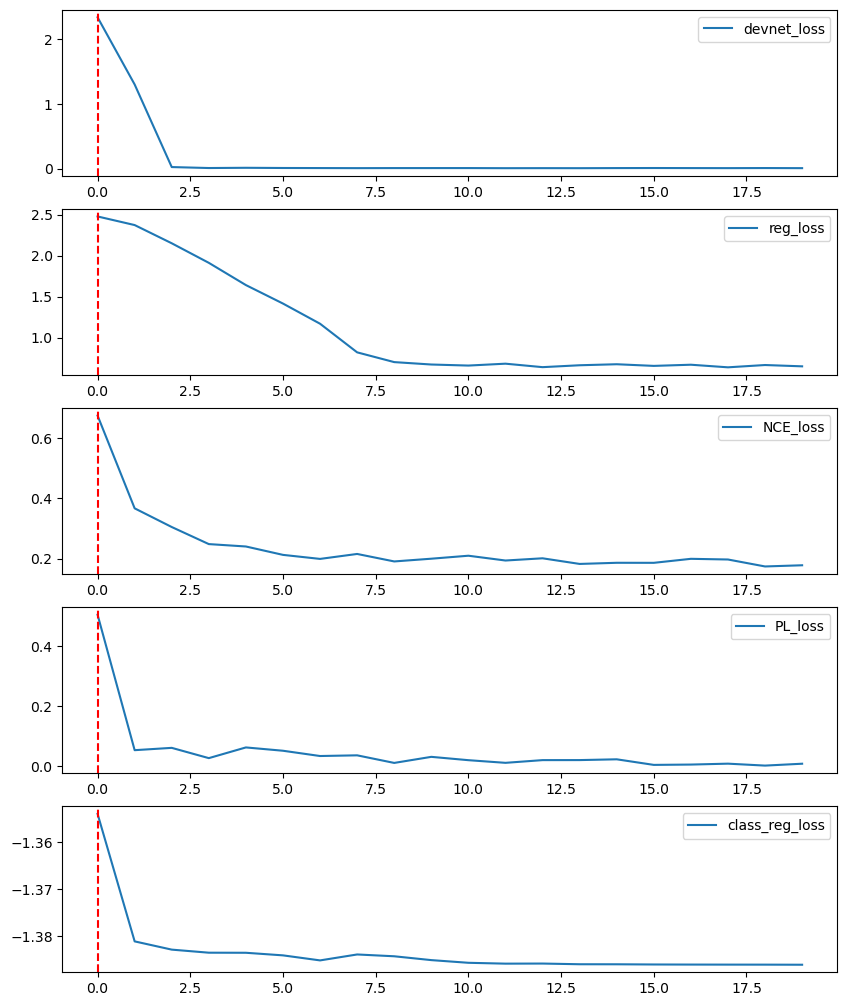

In [31]:
temp = data["sub_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(temp.shape[1],1,figsize=(10,2.5 * temp.shape[1]))
if dir_path.__contains__("method13"):
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
elif dir_path.__contains__("VAE_LPIPS_DEVNET"):
    loss_name_list = ["rec_loss", "kl_loss", "devnet_loss", "reg_loss", "PL_loss", "class_reg_loss"]
else:
    loss_name_list = ["devnet_loss", "reg_loss", "NCE_loss", "PL_loss", "class_reg_loss"]
for idx, label in enumerate(loss_name_list):
    ax[idx].plot(temp[0:,idx], label=label)
    ax[idx].axvline(x=max_val_epoch, color='r', linestyle='--')
    ax[idx].legend()

# for i in range(5):
#     print(temp[0:,i])
print(temp[0:, 1])
plt.show()

In [32]:
temp[0:, 0][-5]

0.007529476773925126

In [33]:
# data["sub_train_results_loss"].mean(axis=1)

In [34]:
if "pre_epochs" in para_name_list:
    temp = []
    for item in file_name.split(","):
        if re.match("epochs=|lr=|reg_lambda", item):
            pass
        else:
            temp.append(item)
    data = np.load(f'../experiment/{",".join(temp)}', allow_pickle=True)

In [35]:
plt.plot(data["pre_train_results_loss"].mean(axis=1))

KeyError: 'pre_train_results_loss is not a file in the archive'

In [ ]:
temp = data["sub_pre_train_results_loss"].mean(axis=1)
fig,ax = plt.subplots(2,1,figsize=(6, 6))
ax[0].plot(temp[0:,0], label="NCE_loss")
ax[1].plot(temp[0:,1], label="PL_loss") 
ax[0].legend()
ax[1].legend()
plt.show()

KeyError: 'sub_pre_train_results_loss is not a file in the archive'

In [ ]:
temp[0:,0]

array([5.12366613e-02, 7.52512779e-04, 2.38156579e-04, 1.11763124e-04,
       9.64891620e-05, 7.81198205e-05, 7.47454518e-05, 6.63250018e-05,
       5.95974552e-05, 5.38587965e-05, 5.10202187e-05, 4.65418390e-05,
       4.23788977e-05, 4.13187449e-05, 4.01404671e-05, 3.87827890e-05,
       3.81627700e-05, 3.65760899e-05, 3.56698465e-05, 3.59697684e-05,
       3.47524817e-05, 3.46994501e-05, 3.51303973e-05, 3.37718926e-05,
       3.41283220e-05, 3.38422307e-05, 3.38356650e-05, 3.35584650e-05,
       3.30837758e-05, 3.34783733e-05])

In [ ]:
temp[0:,1]

array([4.97540535e-01, 1.41077568e-01, 2.41149376e-02, 4.21630200e-02,
       5.27702281e-02, 4.10839084e-02, 4.46073550e-02, 3.27919084e-03,
       1.01064351e-03, 1.06021749e-04, 5.06643846e-05, 2.74663981e-05,
       2.02918835e-05, 1.68948272e-05, 1.48062682e-05, 1.33578818e-05,
       1.22908901e-05, 1.14740167e-05, 1.08376776e-05, 1.03394184e-05,
       9.94086144e-06, 9.62827937e-06, 9.38167218e-06, 9.19360803e-06,
       9.04976189e-06, 8.94778285e-06, 8.87626526e-06, 8.83177576e-06,
       8.80642324e-06, 8.79488158e-06])